<a href="https://colab.research.google.com/github/meishihna/GITHUB-COLAB/blob/main/line_notify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**工具**

In [ ]:
!pip install FinMind
!pip install --upgrade mplfinance

In [2]:
import pandas as pd
# from Data import getDataYF,getDataFM
import mplfinance as mpf
import matplotlib.pyplot as plt

In [34]:
import yfinance as yf
import FinMind
from FinMind.data import DataLoader
datapath = "data"
def getDataYF(prod,st,en):
  data=yf.download(prod,start=st,end=en)
  data.columns=[i.lower() for i in data.columns]
  return data

def getDataFM(prod,st,en):
  FM = DataLoader()
  df = FM.taiwan_stock_daily(stock_id=prod, start_date = st, end_date =en)
## 整理資料格式
  df = df.rename(columns={"date": "Date"})
  df.set_index("Date" , inplace=True)
  df = df.set_index(pd.DatetimeIndex(pd.to_datetime(df.index)))
## backtesting.py 格式
  df1 = df.rename(columns={"open": "Open", "max": "High", "min": "Low", "close": "Close", "Trading_Volume": "Volume"})
## ta-lib 格式
  df2 = df.rename(columns={"max": "high", "min": "low", "Trading_Volume": "Volume"})
  return df1

def getDataFM1(prod,st,en):
  FM = DataLoader()
  df = FM.taiwan_stock_daily(stock_id=prod, start_date = st, end_date =en)
## 整理資料格式
  df = df.rename(columns={"date": "Date"})
  df.set_index("Date" , inplace=True)
  df = df.set_index(pd.DatetimeIndex(pd.to_datetime(df.index)))
## backtesting.py 格式
  df1 = df.rename(columns={"open": "Open", "max": "High", "min": "Low", "close": "Close", "Trading_Volume": "Volume"})
## ta-lib 格式
  df2 = df.rename(columns={"max": "high", "min": "low", "Trading_Volume": "volume"})
  return df2

def ChartCandle(data,addp=[]):
  mcolor = mpf.make_marketcolors(up='r',down='g',inherit = True)
  mstyle = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors = mcolor)
  mpf.plot(data,addplot = addp,style = mstyle,type = 'candle',volume= True)

def ChartTrade(data,trade=pd.DataFrame(),addp=[],v_enable=True):

  addp = addp.copy()
  data1 = data.copy()

  if trade.shape[0] > 0:
    trade1 = trade.copy()
    # 進場明細
    buy_order_trade = trade1[[2,3]]
    buy_order_trade = buy_order_trade.set_index(2)
    buy_order_trade.columns = ['buy_order']
    buy_order_trade = buy_order_trade.drop_duplicates()
    # 出場明細
    buy_cover_trade = trade1[[4,5]]
    buy_cover_trade = buy_cover_trade.set_index(4)
    buy_cover_trade.columns = ['buy_cover']
    buy_cover_trade = buy_cover_trade.drop_duplicates()

    data1 = pd.concat([data1,buy_order_trade,buy_cover_trade], axis = 1)

    addp.append(mpf.make_addplot(data1['buy_order']
            ,type = 'scatter', color = '#FF4500'
            ,marker = '^',markersize = 50))
    addp.append(mpf.make_addplot(data1['buy_cover']
            ,type = 'scatter',color = '#16982B'
            ,marker = 'v',markersize = 50))
  mcolor = mpf.make_marketcolors(up = 'r',down = 'g',inherit = True)
  mstyle = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors = mcolor)
  mpf.plot(data1,addplot = addp,style = mstyle,type = 'candle',volume = v_enable)

# 計算交易績效指標
def Performance(trade=pd.DataFrame(),prodtype='ETF'):
    # 如果沒有交易紀錄 則不做接下來的計算
    if trade.shape[0]==0:
        print('沒有交易紀錄')
        return False

    # 交易成本 手續費0.1425%*2 (券商打折請自行計算)
    if prodtype=='ETF':
        cost=0.001 + 0.00285    # ETF稅金 0.1%
    elif prodtype=='Stock':
        cost=0.003 + 0.00285    # 股票的稅金 0.3%
    else:
        return False

    # 將物件複製出來，不影響原本的變數內容
    trade1=trade.copy()
    trade1=trade1.sort_values(4)
    trade1=trade1.reset_index(drop=True)

    # 給交易明細定義欄位名稱
    trade1.columns=['product','bs','order_time','order_price','cover_time','cover_price','order_unit']
    # 計算出每筆的報酬率
    trade1['ret']=(((trade1['cover_price']-trade1['order_price'])/trade1['order_price'])-cost) *trade1['order_unit']

    # 1.	總報酬率：整個回測期間的總報酬率累加
    print('總績效 %s '%( round(trade1['ret'].sum(),4) ))
    # 2.	總交易次數：代表回測的交易筆數
    print('交易次數 %s '%( trade1.shape[0] ))
    # 3.	平均報酬率：簡單平均報酬率（扣除交易成本後）
    print('平均績效 %s '%( round(trade1['ret'].mean(),4) ))
    # 4.    平均持有時間：代表平均每筆交易的持有時間
    onopen_day=(trade1['cover_time']-trade1['order_time']).mean()
    print('平均持有天數 %s 天'%( onopen_day.days ))
    # 判斷是否獲利跟虧損都有績效
    earn_trade=trade1[trade1['ret'] > 0]
    loss_trade=trade1[trade1['ret'] <= 0]
    if earn_trade.shape[0]==0 or loss_trade.shape[0]==0:
        print('交易資料樣本不足(樣本中需要賺有賠的)')
        return False
    # 5.	勝率：代表在交易次數中，獲利次數的佔比（扣除交易成本後）
    earn_ratio=earn_trade.shape[0] / trade1.shape[0]
    print('勝率 %s '%( round(earn_ratio ,2) ))
    # 6.	平均獲利：代表平均每一次獲利的金額（扣除交易成本後）
    avg_earn=earn_trade['ret'].mean()
    print('平均獲利 %s '%( round(avg_earn,4)))
    # 7.	平均虧損：代表平均每一次虧損的金額（扣除交易成本後）
    avg_loss=loss_trade['ret'].mean()
    print('平均虧損 %s '%( round(avg_loss,4) ))
    # 8.	賺賠比：代表平均獲利 / 平均虧損
    odds=abs(avg_earn/avg_loss)
    print('賺賠比 %s '%( round(odds,4) ))
    # 9.	期望值：代表每投入的金額，可能會回報的多少倍的金額
    print('期望值 %s '%( round(((earn_ratio*odds)-(1-earn_ratio)),4) ))
    # 10.	獲利平均持有時間：代表獲利平均每筆交易的持有時間
    earn_onopen_day=(earn_trade['cover_time']-earn_trade['order_time']).mean()
    print('獲利平均持有天數 %s 天'%( earn_onopen_day.days ))
    # 11.	虧損平均持有時間：代表虧損平均每筆交易的持有時間
    loss_onopen_day=(loss_trade['cover_time']-loss_trade['order_time']).mean()
    print('虧損平均持有天數 %s 天'%( loss_onopen_day.days ))

    # 12.	最大連續虧損：代表連續虧損的最大幅度
    tmp_accloss=1
    max_accloss=1
    for ret in trade1['ret'].values:
        if ret <= 0:
            tmp_accloss *= ret
            max_accloss= min(max_accloss,tmp_accloss)
        else:
            tmp_accloss = 1
    print('最大連續虧損',round(max_accloss ,4))

    # 優先計算累計報酬率 並將累計報酬率的初始值改為1 繪圖較容易閱讀
    trade1['acc_ret'] = (1+trade1['ret']).cumprod()
    trade1.loc[-1,'acc_ret'] = 1
    trade1.index = trade1.index + 1
    trade1.sort_index(inplace=True)

    # 13.	最大資金回落：代表資金從最高點回落至最低點的幅度
    trade1['acc_max_cap'] = trade1['acc_ret'].cummax()
    trade1['dd'] = (trade1['acc_ret'] / trade1['acc_max_cap'])
    trade1.loc[trade1['acc_ret'] == trade1['acc_max_cap'] , 'new_high'] = trade1['acc_ret']
    print('最大資金回落',round(1-trade1['dd'].min(),4))

    # 14.	繪製資金曲線圖(用幾何報酬計算)
    ax=plt.subplot(111)
    ax.plot( trade1['acc_ret'] , 'b-' ,label='Profit')
    ax.plot( trade1['dd'] , '-' ,color='#00A600',label='MDD')
    ax.plot( trade1['new_high'] , 'o' ,color='#FF0000',label='Equity high')
    ax.legend()
    plt.show()

    return trade1

###**TALIB**

In [ ]:
!pip install ta-lib-bin > log.txt
!pip install Ta-Lib

In [69]:
import talib
from talib import SMA as func_sma
from talib.abstract import SMA as abs_sma
from talib.abstract import EMA

In [ ]:
prod = '0050'
data = getDataFM1(prod,'2007-01-01','2022-05-01')
# EMA(data,timeperiod=120)
data['ema'] = EMA(data,timeperiod=120)

addp=[]
addp.append(mpf.make_addplot(data['ema']))

ChartTrade(data,addp=addp)

###**YF**

In [ ]:
# from Data import getDataYF
data = getDataYF('0050.TW','2010-01-01','2025-01-01')
data.head()

In [ ]:
mpf.plot(data)

In [ ]:
mpf.plot(data,type='candle')

###**FM**

####資料

In [ ]:
data = getDataFM('2331','2020-01-01','2025-01-01')
data.head()
#　FM = DataLoader()
# Data = FM.taiwan_stock_daily_adj(stock_id='0050',start_date='2010-01-01',end_date='2025-01-01')
# Data.head()

2024-01-22 10:05:44.162 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2331


,stock_id,Volume,Trading_money,Open,High,Low,Close,spread,Trading_turnover
Date,,,,,,,,,
2020-01-02,2331,459476,6364260,13.70,14.00,13.70,13.95,0.25,245
2020-01-03,2331,348524,4791223,14.00,14.00,13.60,13.60,-0.35,235
2020-01-06,2331,680451,9284353,13.60,13.75,13.45,13.75,0.15,277
2020-01-07,2331,554758,7525216,13.70,13.85,13.45,13.45,-0.30,271
2020-01-08,2331,501103,6690311,13.45,13.55,13.25,13.35,-0.10,217


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


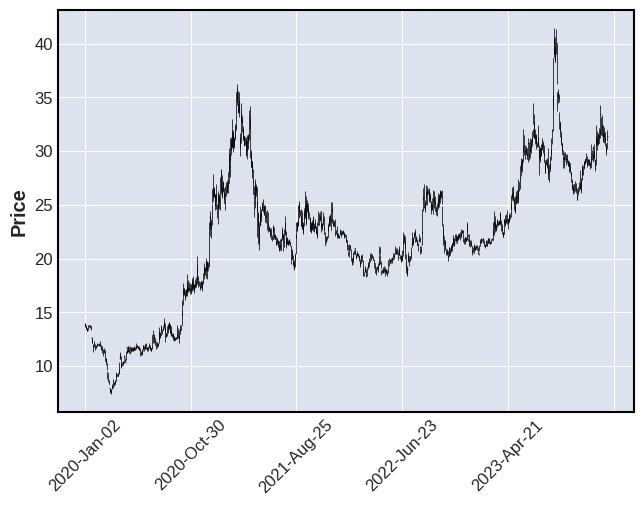

In [ ]:
mpf.plot(data)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


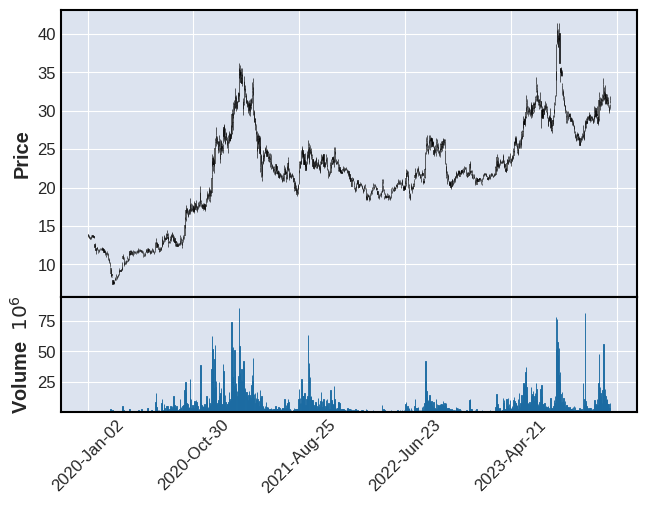

In [ ]:
mpf.plot(data,type='candle',volume=True)

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


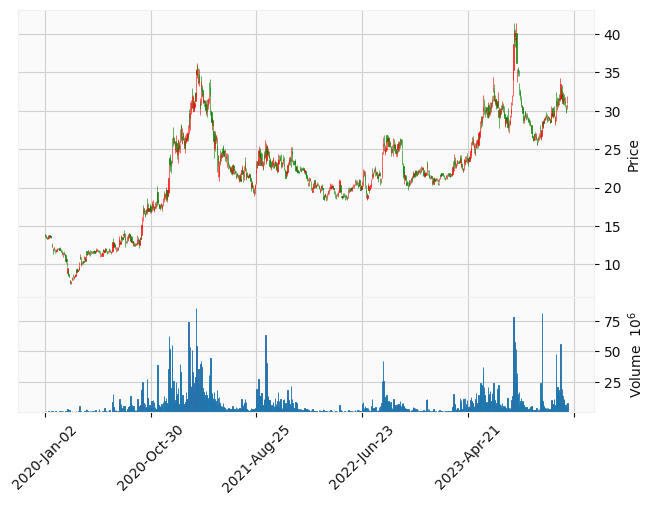

In [ ]:
ChartCandle(data)

In [ ]:
position = 0
for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_low = data.loc[c_time,'Low']
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_open = data.loc[c_time,'Open']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_open and (c_close - c_open)* 2 < (c_open - c_low):
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if i > order_i + 3 and c_close > c_open:
      position = 0
      cover_time = n_time
      cover_price = n_open
      print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)


####記錄回測明細

In [ ]:
import pandas as pd

prod = '0050'
data = getDataFM(prod,'2018-01-01','2022-05-01')

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_low = data.loc[c_time,'Low']
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_open = data.loc[c_time,'Open']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_open and (c_close - c_open)* 2 < (c_open - c_low):
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if i > order_i + 3 and c_close > c_open:
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

# print(trade)

In [ ]:
print(trade)

       0    1          2       3          4       5  6
0   0050  Buy 2018-01-10   84.10 2018-01-16   84.65  1
1   0050  Buy 2018-01-29   85.50 2018-02-02   84.85  1
2   0050  Buy 2018-02-05   83.20 2018-02-12   79.55  1
3   0050  Buy 2018-02-22   81.50 2018-03-02   80.85  1
4   0050  Buy 2018-03-22   84.00 2018-03-28   82.90  1
5   0050  Buy 2018-04-10   82.10 2018-04-20   81.00  1
6   0050  Buy 2018-04-26   79.70 2018-05-07   79.50  1
7   0050  Buy 2018-06-26   80.70 2018-07-02   81.50  1
8   0050  Buy 2018-08-10   85.70 2018-08-17   83.95  1
9   0050  Buy 2018-08-21   83.90 2018-08-28   85.95  1
10  0050  Buy 2018-10-09   83.05 2018-10-17   80.45  1
11  0050  Buy 2018-11-06   78.45 2018-11-13   76.15  1
12  0050  Buy 2018-11-15   77.50 2018-11-22   76.10  1
13  0050  Buy 2018-11-28   76.15 2018-12-04   78.50  1
14  0050  Buy 2018-12-14   75.80 2018-12-20   75.00  1
15  0050  Buy 2019-01-25   74.60 2019-02-13   75.95  1
16  0050  Buy 2019-02-27   77.70 2019-03-07   76.90  1
17  0050  

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


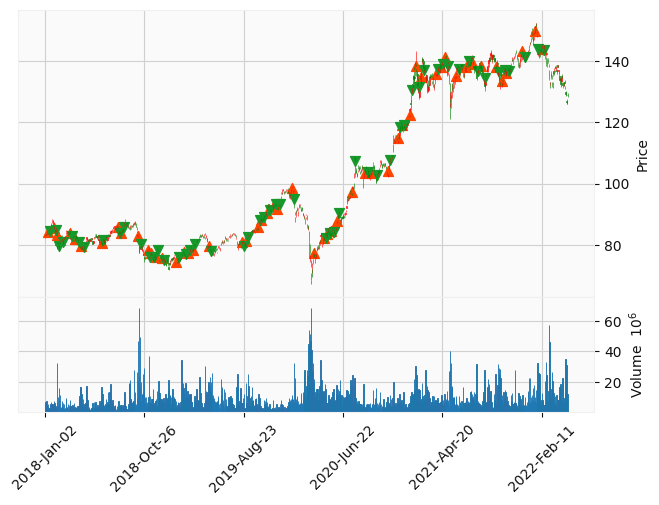

In [ ]:
ChartTrade(data,trade)

總績效-0.0646
交易次數55
平均績效-0.0012
平均持有天數8天
勝率0.47
平均獲利0.0194
平均虧損-0.0196
賺賠比0.9898
期望值-0.0594
獲利平均持有天數8 days 00:00:00天
最大資金回落 0.1837


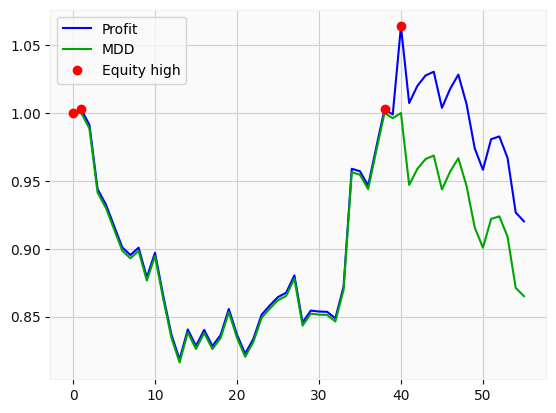

/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


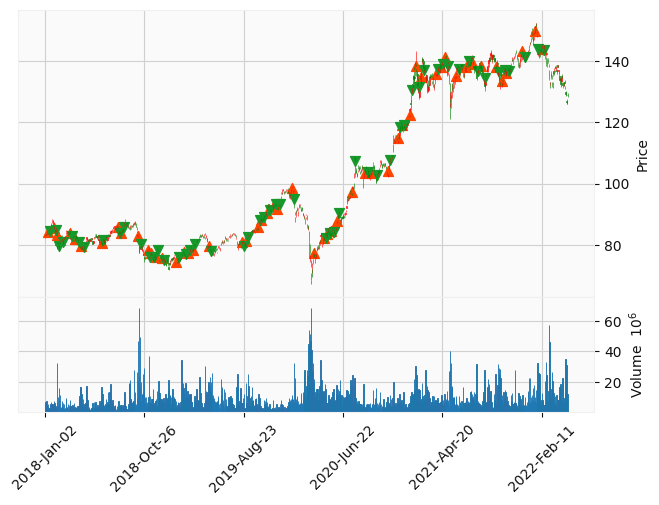

In [ ]:
Performance(trade,'ETF')
ChartTrade(data,trade)

###**突破均線交易**

In [ ]:
prod = '0050'
data = getDataFM1(prod,'2007-01-01','2022-05-01')
# EMA(data,timeperiod=120)
data['ema'] = EMA(data,timeperiod=120)

movestoploss = 0.05

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_high = data.loc[c_time,'high']
  c_close = data.loc[c_time,'close']
  c_ema = data.loc[c_time,'ema']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'open']

  if position == 0 :
    if c_close > c_ema*1.01 :
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if c_close < c_ema * 0.995:
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

addp = []
addp.append(mpf.make_addplot(data['ema']))

Performance(trade,'ETF')
ChartTrade(data,trade,addp=addp)

###**趨勢突破策略**

2024-01-23 01:21:38.094 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 00878
<ipython-input-11-599259bb888a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-11-599259bb888a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-11-599259bb888a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-11-599259bb888a>:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-11-599259bb888a>:34: FutureWarning: The frame.appe

總績效-0.0411
交易次數38
平均績效-0.0011
平均持有天數4天
勝率0.42
平均獲利0.0113
平均虧損-0.0101
賺賠比1.1188
期望值-0.1079
獲利平均持有天數7 days 09:00:00天
最大資金回落 0.0964


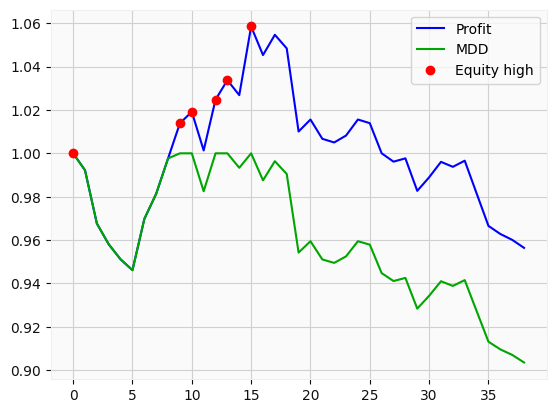

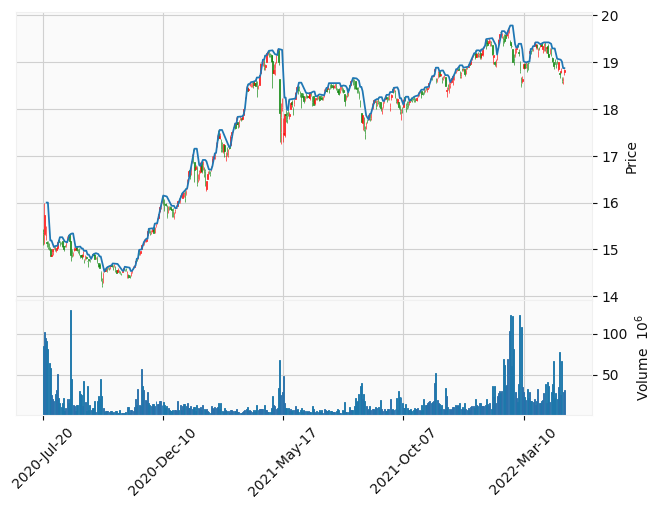

In [ ]:
prod = '00878'
data = getDataFM(prod,'2007-01-01','2022-05-01')

data['Ceil'] = data.rolling(3)['High'].max().shift()

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_ceil = data.loc[c_time,'Ceil']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_ceil :
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if c_high < c_ceil:
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

addp = []
addp.append(mpf.make_addplot(data['Ceil']))
Performance(trade,'ETF')
ChartTrade(data,addp=addp)

####趨勢突破策略(停利/停損)

In [ ]:
prod = '0050'
data = getDataFM(prod,'2007-01-01','2022-05-01')

data['Ceil'] = data.rolling(3)['High'].max().shift()
takeprofit = 0.12
stoploss = 0.05

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_ceil = data.loc[c_time,'Ceil']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_ceil :
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if c_close > order_price * (1 + takeprofit) or c_close < order_price * (1-stoploss):
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

addp = []
addp.append(mpf.make_addplot(data['Ceil']))
Performance(trade,'ETF')
ChartTrade(data,trade,addp=addp)

####趨勢突破策略(移動停利/移動停損)

In [ ]:
prod = '0050'
data = getDataFM(prod,'2007-01-01','2022-05-01')

data['Ceil'] = data.rolling(3)['High'].max().shift()

movestoploss = 0.05

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_high = data.loc[c_time,'High']
  c_close = data.loc[c_time,'Close']
  c_ceil = data.loc[c_time,'Ceil']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'Open']

  if position == 0 :
    if c_close > c_ceil :
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      stoploss = order_price * (1 - movestoploss)
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    stoploss = max(stoploss,c_close * (1 - movestoploss))
    if c_close < stoploss:
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

addp = []
addp.append(mpf.make_addplot(data['Ceil']))
Performance(trade,'ETF')
ChartTrade(data,trade,addp=addp)

###**大股東資料**

####工具

In [4]:
import os
import numpy as np

In [13]:
def getFMShareHolder(prod,st,en):
  bakfile = '%s_%s_%s_stock_holding_shares_per.csv'%(prod,st,en)

  if os.path.exists(bakfile):
    tmpdata=pd.read_csv(bakfile)
    tmpdata['date']=pd.to_datetime(tmpdata['date'])
    tmpdata=tmpdata.set_index(tmpdata['date'])

  else:
    tmpdata=FM.taiwan_stock_holding_shares_per(stock_id=prod,start_date=st,end_date=en)
    tmpdata['date']=pd.to_datetime(tmpdata['date'])
    tmpdata=tmpdata.set_index(tmpdata['date'])
    tmpdata.drop('date',axis=1,inplace=True)
    tmpdata.to_csv(bakfile)

  return tmpdata

def ShareHolderWeekly(data):
  rs_sh,rs_dt=[],[]

  for dt in data.index.unique():
    data1=data[data.index==dt]

    tmprow = data1.loc[data1['HoldingSharesLevel']=='1-999','percent'].values # 1
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='1,000-5,000','percent'].values) # 2
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='5,001-10,000','percent'].values) # 3
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='10,001-15,000','percent'].values) # 4
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='15,001-20,000','percent'].values) # 5
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='20,001-30,000','percent'].values) # 6
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='30,001-40,000','percent'].values) # 7
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='40,001-50,000','percent'].values) # 8
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='50,001-100,000','percent'].values) # 9
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='100,001-200,000','percent'].values) # 10
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='200,001-400,000','percent'].values) # 11
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='400,001-600,000','percent'].values) # 12
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='600,001-800,000','percent'].values) # 13
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='800,001-1,000,000','percent'].values) # 14
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='more than 1,000,001','percent'].values) # 15
    tmprow = np.append(tmprow,data1.loc[data1['HoldingSharesLevel']=='total','people'].values) # 16

    rs_sh.append(tmprow)
    rs_dt.append(dt)

  rs=pd.DataFrame(rs_sh,index=rs_dt,columns=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','total_people'])
  return rs

def getPriceAndShareHolder(prod,st,en):
  data1=getDataFM(prod,st,en)
  data2=getFMShareHolder(prod,st,en)
  data2a=ShareHolderWeekly(data2)

  for i in range(1,data2a.shape[0]):
    tmpdata=data1.loc[(data1.index>data2a.index[i-1])&(data1.index<=data2a.index[i]),]
    if tmpdata.shape[0] == 0:
      continue
    data2a.loc[data2a.index[i],'open']=tmpdata.loc[tmpdata.index[0],'Open']
    data2a.loc[data2a.index[i],'high']=tmpdata.loc[:,'High'].max()
    data2a.loc[data2a.index[i],'low']=tmpdata.loc[:,'Low'].min()
    data2a.loc[data2a.index[i],'close']=tmpdata.loc[tmpdata.index[-1],'Close']
    data2a.loc[data2a.index,'volume']=tmpdata.loc[:,'Volume'].sum()

  data2a = data2a.dropna()
  return data2a

In [8]:
data = getFMShareHolder('0050','2020-01-01','2022-01-01')
data.head()

2024-01-24 02:00:00.942 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockHoldingSharesPer, data_id: 0050


,stock_id,HoldingSharesLevel,people,percent,unit
date,,,,,
2020-01-03,0050,1-999,35739,1.33,9159937
2020-01-03,0050,"1,000-5,000",47374,12.91,88697421
2020-01-03,0050,"10,001-15,000",1241,2.32,15952164
2020-01-03,0050,"100,001-200,000",101,2.09,14407156
2020-01-03,0050,"15,001-20,000",686,1.82,12524289


In [11]:
data = ShareHolderWeekly(data)

In [16]:
data = getPriceAndShareHolder('0050','2007-01-01','2022-05-01')
data

2024-01-24 02:06:17.555 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 0050
2024-01-24 02:06:20.130 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockHoldingSharesPer, data_id: 0050


,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,total_people,open,high,low,close,volume
2015-05-08,0.11,5.10,2.56,1.11,1.20,1.24,0.82,0.79,1.84,1.73,...,1.14,0.69,0.69,79.24,36733.0,71.45,71.65,70.15,70.50,101246816.0
2015-05-15,0.11,5.28,2.66,1.21,1.27,1.32,0.90,0.78,2.02,1.78,...,1.29,0.82,0.84,77.94,37875.0,71.00,71.20,69.70,70.00,101246816.0
2015-05-22,0.11,5.33,2.68,1.24,1.29,1.34,0.90,0.84,2.02,1.86,...,1.28,0.97,0.76,77.69,38478.0,70.05,71.45,69.75,70.70,101246816.0
2015-05-29,0.11,5.24,2.61,1.22,1.24,1.31,0.86,0.83,2.03,1.85,...,1.29,0.90,0.92,78.05,37895.0,70.45,71.90,70.30,71.10,101246816.0
2015-06-05,0.11,5.76,2.90,1.36,1.38,1.51,0.93,0.94,2.16,2.00,...,1.50,0.88,0.97,75.76,39566.0,71.10,71.15,68.20,68.45,101246816.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,4.50,20.99,8.28,3.83,2.59,3.12,1.82,1.19,2.84,1.94,...,0.93,0.69,0.65,45.16,491075.0,137.00,138.70,135.55,136.95,101246816.0
2022-04-08,4.56,21.33,8.44,3.89,2.66,3.17,1.83,1.18,2.89,1.93,...,0.91,0.67,0.63,44.42,499941.0,135.25,136.35,133.75,134.55,101246816.0
2022-04-15,4.60,21.52,8.51,3.95,2.66,3.19,1.82,1.19,2.88,1.91,...,0.89,0.68,0.74,43.92,507673.0,134.15,135.75,131.60,132.25,101246816.0
2022-04-22,4.56,21.64,8.61,4.08,2.68,3.18,1.86,1.22,2.99,1.89,...,0.93,0.66,0.65,43.49,517485.0,132.00,133.60,130.85,131.60,101246816.0


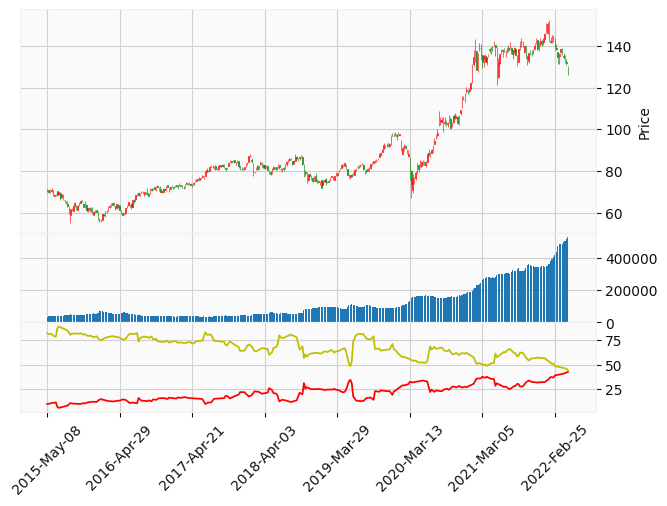

In [19]:
data['minority'] = data['1'] + data['2'] + data['3'] + data['4'] + data['5'] # 30張以下為散戶
data['major'] = data['12'] + data['13'] + data['14'] + data['15'] #400張以上為大戶
addp = []
addp.append(mpf.make_addplot(data['total_people'],panel = 1,type = 'bar',secondary_y = False)) # 總股東人數
addp.append(mpf.make_addplot(data['minority'],panel = 2,secondary_y = False,color = 'r')) # 散戶人數
addp.append(mpf.make_addplot(data['major'],panel = 2,secondary_y = False,color = 'y')) # 大戶人數

ChartTrade(data,addp=addp,v_enable = False)

####跟著大戶策略

2024-01-24 02:59:30.218 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 0050
<ipython-input-28-b47b3412c08f>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-28-b47b3412c08f>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-28-b47b3412c08f>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-28-b47b3412c08f>:39: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade = trade.append(pd.Series([
<ipython-input-28-b47b3412c08f>:39: FutureWarning: The frame.appen

總績效 0.1654 
交易次數 12 
平均績效 0.0138 
平均持有天數 48 天
勝率 0.58 
平均獲利 0.0465 
平均虧損 -0.0321 
賺賠比 1.4513 
期望值 0.4299 
獲利平均持有天數 47 天
虧損平均持有天數 48 天
最大連續虧損 -0.0546
最大資金回落 0.1043


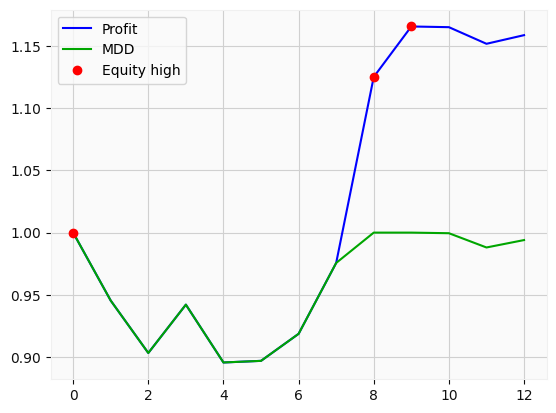

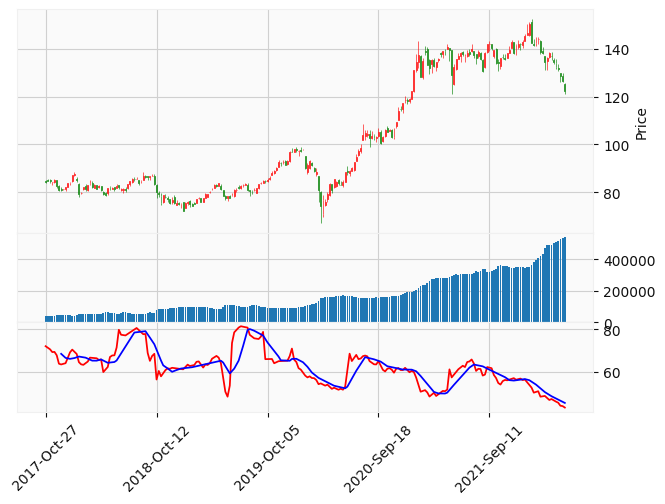

In [28]:
prod = '0050'
data = getPriceAndShareHolder(prod,'2017-10-20','2022-05-18')

data['major'] = data['12'] + data['13'] + data['14'] + data['15'] #400張以上為大戶
data['major_ma'] = data.rolling(8)['major'].mean()
data['total_people_ma'] = data.rolling(8)['total_people'].mean()

position = 0
trade = pd.DataFrame()

for i in range(data.shape[0]-1):
  c_time = data.index[i]
  c_high = data.loc[c_time,'high']
  c_close = data.loc[c_time,'close']
  c_major = data.loc[c_time,'major']
  c_major_ma = data.loc[c_time,'major_ma']
  c_total_people = data.loc[c_time,'total_people']
  c_total_people_ma = data.loc[c_time,'total_people_ma']

  n_time = data.index[i+1]
  n_open = data.loc[n_time,'open']

  if position == 0 :
    if c_major > c_major_ma and c_total_people > c_total_people_ma :
      position = 1
      order_i = i
      order_time = n_time
      order_price = n_open
      order_unit = 1
      # print(c_time,'觸發進場訊號 隔日進場', order_time,'進場價', order_price, '進場', order_unit,'單位')

  elif position == 1 :
    if c_major < c_major_ma:
      position = 0
      cover_time = n_time
      cover_price = n_open
      # print(c_time,'觸發出場訊號 隔日出場', order_time, '出場價', order_price)

      trade = trade.append(pd.Series([
              prod,
              'Buy',
              order_time,
              order_price,
              cover_time,
              cover_price,
              order_unit
          ]),ignore_index = True)

addp = []
#　addp.append(mpf.make_addplot(data['ma'],color='r'))
addp.append(mpf.make_addplot(data['total_people'],panel=1,type='bar'))
addp.append(mpf.make_addplot(data['major'],panel=2,secondary_y=False,color='r'))
addp.append(mpf.make_addplot(data['major_ma'],panel=2,secondary_y=False,color='b'))

Performance(trade,'ETF')
ChartTrade(data,addp=addp,v_enable=False)


####反著散戶策略

2024-01-24 03:00:12.159 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 0050
<ipython-input-29-fa15edcbe3cd>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade=trade.append(pd.Series([
<ipython-input-29-fa15edcbe3cd>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade=trade.append(pd.Series([
<ipython-input-29-fa15edcbe3cd>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade=trade.append(pd.Series([
<ipython-input-29-fa15edcbe3cd>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trade=trade.append(pd.Series([
<ipython-input-29-fa15edcbe3cd>:47: FutureWarning: The frame.append method

總績效 0.1957 
交易次數 25 
平均績效 0.0078 
平均持有天數 40 天
勝率 0.52 
平均獲利 0.0391 
平均虧損 -0.0261 
賺賠比 1.5004 
期望值 0.3002 
獲利平均持有天數 47 天
虧損平均持有天數 32 天
最大連續虧損 -0.0723
最大資金回落 0.1135


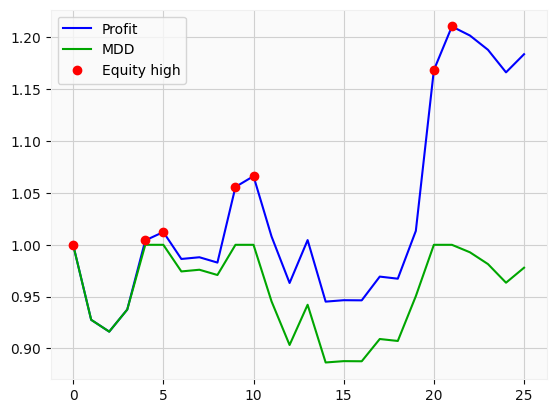

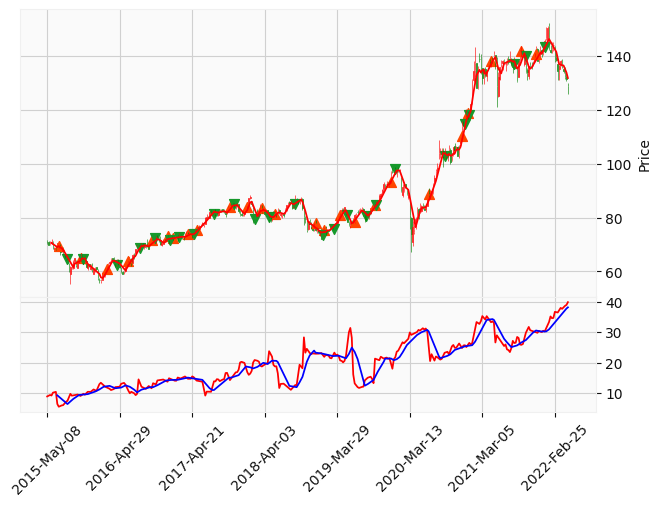

In [29]:
# 取得回測資料
prod='0050'
data=getPriceAndShareHolder(prod,'2007-01-01','2022-05-01')

# 30張持有以下稱為散戶
data['minority']=data['1']+data['2']+data['3']+data['4']

# 算出過去的平均
data['minority_ma']=data.rolling(8)['minority'].mean()
data['ma']=data.rolling(4)['close'].mean()
data['total_people_ma']=data.rolling(8)['total_people'].mean()

# 初始部位
position=0
trade=pd.DataFrame()
# 開始回測
for i in range(data.shape[0]-1):
    # 取得策略會應用到的變數
    c_time=data.index[i]
    c_high=data.loc[c_time,'high']
    c_close=data.loc[c_time,'close']
    c_ma=data.loc[c_time,'ma']
    c_minority=data.loc[c_time,'minority']
    c_minority_ma=data.loc[c_time,'minority_ma']
    c_total_people=data.loc[c_time,'total_people']
    c_total_people_ma=data.loc[c_time,'total_people_ma']
    # 取下一期資料做為進場資料
    n_time=data.index[i+1]
    n_open=data.loc[n_time,'open']

    # 進場程序
    if position == 0 :
        if c_close > c_ma and c_minority < c_minority_ma :
            position = 1
            order_i=i
            order_time=n_time
            order_price=n_open
            order_unit=1
    # 出場程序
    elif position ==1 :
        # 出場邏輯
        if c_minority > c_minority_ma:
            position = 0
            cover_time=n_time
            cover_price=n_open
            # 交易紀錄
            trade=trade.append(pd.Series([
                        prod,
                        'Buy',
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit
                    ]),ignore_index=True)


# 繪製副圖
addp=[]
addp.append(mpf.make_addplot(data['ma'],color='r'))
addp.append(mpf.make_addplot(data['minority'],panel=1,secondary_y=False,color='r'))
addp.append(mpf.make_addplot(data['minority_ma'],panel=1,secondary_y=False,color='b'))

# 績效分析
Performance(trade,'ETF')
# 繪製K線圖與交易明細
ChartTrade(data,trade,addp=addp,v_enable=False)

###**三大法人**

####工具

In [32]:
# 取得三大法人 FinMind資料來源
def getFMInstitutionalInvestors(prod, st, en):
    # 備份檔名
    bakfile = (
        f"{datapath}\\{prod}_{st}_{en}_TaiwanStockInstitutionalInvestorsBuySell.csv"
    )
    # 檢視是否有該檔案存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
    # 沒有的話就取API內容
    else:
        tmpdata = FM.taiwan_stock_institutional_investors(
            stock_id=prod, start_date=st, end_date=en
        )
        # 將日期設定為索引
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
        tmpdata.drop("date", axis=1, inplace=True)
        # 將API內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    return tmpdata

# 將三大法人轉換為一日一筆
def InstInvestorsDaily(data):
    rs_sh, rs_dt = [], []
    # 依照日期去將資料做整合
    for dt in data.index.unique():
        # 撈出當天的所有資料
        data1 = data[data.index == dt]
        # 依照不同交易人類別
        tmprow = []
        f_b = data1.loc[data1["name"] == "Foreign_Investor", "buy"].values
        f_s = data1.loc[data1["name"] == "Foreign_Investor", "sell"].values
        fd_b = data1.loc[data1["name"] == "Foreign_Dealer_Self", "buy"].values
        fd_s = data1.loc[data1["name"] == "Foreign_Dealer_Self", "sell"].values
        i_b = data1.loc[data1["name"] == "Investment_Trust", "buy"].values
        i_s = data1.loc[data1["name"] == "Investment_Trust", "sell"].values
        d_b = data1.loc[data1["name"] == "Dealer", "buy"].values
        d_s = data1.loc[data1["name"] == "Dealer", "sell"].values
        ds_b = data1.loc[data1["name"] == "Dealer_self", "buy"].values
        ds_s = data1.loc[data1["name"] == "Dealer_self", "sell"].values
        dh_b = data1.loc[data1["name"] == "Dealer_Hedging", "buy"].values
        dh_s = data1.loc[data1["name"] == "Dealer_Hedging", "sell"].values
        # 如果為空 則填入該欄位為0
        if len(f_b) == 0:
            tmprow.append(0)
        else:
            tmprow.append(f_b[0])
        if len(f_s) == 0:
            tmprow.append(0)
        else:
            tmprow.append(f_s[0])
        if len(fd_b) == 0:
            tmprow.append(0)
        else:
            tmprow.append(fd_b[0])
        if len(fd_s) == 0:
            tmprow.append(0)
        else:
            tmprow.append(fd_s[0])
        if len(i_b) == 0:
            tmprow.append(0)
        else:
            tmprow.append(i_b[0])
        if len(i_s) == 0:
            tmprow.append(0)
        else:
            tmprow.append(i_s[0])
        if len(d_b) == 0:
            tmprow.append(0)
        else:
            tmprow.append(d_b[0])
        if len(d_s) == 0:
            tmprow.append(0)
        else:
            tmprow.append(d_s[0])
        if len(ds_b) == 0:
            tmprow.append(0)
        else:
            tmprow.append(ds_b[0])
        if len(ds_s) == 0:
            tmprow.append(0)
        else:
            tmprow.append(ds_s[0])
        if len(dh_b) == 0:
            tmprow.append(0)
        else:
            tmprow.append(dh_b[0])
        if len(dh_s) == 0:
            tmprow.append(0)
        else:
            tmprow.append(dh_s[0])
        # 將DF資料存放到容器
        rs_sh.append(tmprow)
        # 資料日期存成一個列表
        rs_dt.append(dt)
    # 將每日的資料整合
    rs = pd.DataFrame(
        rs_sh,
        index=rs_dt,
        columns=[
            "外陸資買進股數(不含外資自營商)",
            "外陸資賣出股數(不含外資自營商)",
            "外資自營商買進股數",
            "外資自營商賣出股數",
            "投信買進股數",
            "投信賣出股數",
            "自營商買進股數(自行買賣)_1",
            "自營商賣出股數(自行買賣)_1",
            "自營商買進股數(自行買賣)_2",
            "自營商賣出股數(自行買賣)_2",
            "自營商買進股數(避險)",
            "自營商賣出股數(避險)",
        ],
    )
    # 由於FinMind的，自營商類別有兩個，所以必須將這個了欄位合併，
    rs["自營商買進股數(自行買賣)"] = rs["自營商買進股數(自行買賣)_1"] + rs["自營商買進股數(自行買賣)_2"]
    rs["自營商賣出股數(自行買賣)"] = rs["自營商賣出股數(自行買賣)_1"] + rs["自營商賣出股數(自行買賣)_2"]
    rs.drop("自營商買進股數(自行買賣)_1", axis=1, inplace=True)
    rs.drop("自營商買進股數(自行買賣)_2", axis=1, inplace=True)
    rs.drop("自營商賣出股數(自行買賣)_1", axis=1, inplace=True)
    rs.drop("自營商賣出股數(自行買賣)_2", axis=1, inplace=True)
    return rs

# 取得K線與三大法人的集合資料 透過 FinMind
def getPriceAndInstInvest_FM(prod, st, en):
    # 取得還原股價
    data1 = getDataFM(prod, st, en)
    # 取得三大法人
    data2 = getFMInstitutionalInvestors(prod, st, en)
    # 轉換資料格式
    data2_1 = InstInvestorsDaily(data2)
    data3 = pd.concat([data1, data2_1], axis=1, join="inner")
    return data3

####跟著外資策略

In [ ]:
# 取得回測資料
prod='0050'
data=getPriceAndInstInvest_FM(prod,'2019-05-01','2022-05-01')

# 計算 外資平均買賣
data['F_day']=data['外陸資買進股數(不含外資自營商)']-data['外陸資賣出股數(不含外資自營商)']
data['F_month']=(data['F_day']).rolling(40).sum()
data['F_mean']=(data['F_month']).rolling(20).mean()

# 初始部位
position=0
trade=pd.DataFrame()
# 開始回測
for i in range(data.shape[0]-1):
    # 取得策略會應用到的變數
    c_time=data.index[i]
    c_high=data.loc[c_time,'High']
    c_close=data.loc[c_time,'Close']
    c_F_month=data.loc[c_time,'F_month']
    c_F_mean=data.loc[c_time,'F_mean']
    # 取下一期資料做為進場資料
    n_time=data.index[i+1]
    n_open=data.loc[n_time,'Open']

    # 進場程序
    if position == 0 :
        if c_F_month > c_F_mean :
            position = 1
            order_i=i
            order_time=n_time
            order_price=n_open
            order_unit=1
    # 出場程序
    elif position ==1 :
        # 出場邏輯
        if c_F_month < c_F_mean :
            position = 0
            cover_time=n_time
            cover_price=n_open
            # 交易紀錄
            trade=trade.append(pd.Series([
                        prod,
                        'Buy',
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit
                    ]),ignore_index=True)

# 繪製副圖
addp=[]
# 外資買賣力道
addp.append(mpf.make_addplot(data['F_month'],panel=1,color='red',secondary_y=False))
addp.append(mpf.make_addplot(data['F_mean'],panel=1,color='blue',secondary_y=False))

# 績效分析
Performance(trade,'ETF')
# 繪製K線圖與交易明細
ChartTrade(data,trade,addp=addp,v_enable=False)

In [88]:
import datetime
# 取得回測資料
prod='2331'
st='2010-01-01'
en=datetime.datetime.now().strftime('%Y-%m-%d')
data=getPriceAndInstInvest_FM(prod,st,en)

# 計算 外資平均買賣
data['F_day']=data['外陸資買進股數(不含外資自營商)']-data['外陸資賣出股數(不含外資自營商)']
data['F_month']=(data['F_day']).rolling(40).sum()
data['F_mean']=(data['F_month']).rolling(20).mean()
# 初始部位
position=0
# 當天訊號
signal=0

for i in range(data.shape[0]-1):
    # 取得策略會應用到的變數
    c_time=data.index[i]
    c_high=data.loc[c_time,'High']
    c_close=data.loc[c_time,'Close']
    c_F_month=data.loc[c_time,'F_month']
    c_F_mean=data.loc[c_time,'F_mean']
    # 取下一期資料做為進場資料
    n_time=data.index[i+1]
    n_open=data.loc[n_time,'Open']

    # 進場程序
    if position == 0 :
        if c_F_month > c_F_mean :
            position = 1
            signal = 3
        else :
            signal = 1
    # 出場程序
    elif position ==1 :
        # 出場邏輯
        if c_F_month < c_F_mean :
            position = 0
            signal = 4
        else:
            signal = 2

strategy_name='均線策略'
if signal==1:
    line_print('%s \n %s \n %s \n維持空手'%(strategy_name,prod,en))
elif signal==2:
    line_print('%s \n %s \n %s \n維持進場'%(strategy_name,prod,en))
elif signal==3:
    line_print('%s \n %s \n %s \n進場訊號'%(strategy_name,prod,en))
elif signal==4:
    line_print('%s \n %s \n %s \n出場訊號'%(strategy_name,prod,en))

2024-01-24 05:02:10.621 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2331


均線策略 
 2331 
 2024-01-24 
維持進場


###**融資融券**

####工具

In [38]:
# 取得融資融券 FinMind資料來源
def getFMMarginTrading(prod, st, en):
    # 備份檔名
    bakfile = (
        f"{datapath}\\{prod}_{st}_{en}_taiwan_stock_margin_purchase_short_sale.csv"
    )
    # 檢視是否有該檔案存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
    # 沒有的話就取API內容
    else:
        tmpdata = FM.taiwan_stock_margin_purchase_short_sale(
            stock_id=prod, start_date=st, end_date=en
        )
        # 將日期設定為索引
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
        tmpdata.drop("date", axis=1, inplace=True)
        # 將API內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    return tmpdata

# 取得融券借券 FinMind資料來源
def getFMShortSales(prod, st, en):
    # 備份檔名
    bakfile = f"{datapath}\\{prod}_{st}_{en}_taiwan_daily_short_sale_balances.csv"
    # 檢視是否有該檔案存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
    # 沒有的話就取API內容
    else:
        tmpdata = FM.taiwan_daily_short_sale_balances(
            stock_id=prod, start_date=st, end_date=en
        )
        # 將日期設定為索引
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
        tmpdata.drop("date", axis=1, inplace=True)
        # 將API內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    return tmpdata

# 取得股價以及融資融券 FinMind資料來源
def getFMPriceAndMarginTrade(prod, st, en):
    data1 = getDataFM(prod, st, en)
    data2 = getFMMarginTrading(prod, st, en)
    data3 = pd.concat([data1, data2], axis=1, join="inner")
    return data3


# 取得股價以及融券借券 FinMind資料來源
def getFMPriceAndShortSales(prod, st, en):
    data1 = getDataFM(prod, st, en)
    data2 = getFMShortSales(prod, st, en)
    data3 = pd.concat([data1, data2], axis=1, join="inner")
    return data3

####融資融券交易策略

In [ ]:
# 取得回測資料
prod='2330'
data=getFMPriceAndMarginTrade(prod,'2019-01-01','2022-05-01')

# 融資融券餘額
data['mb']=data['MarginPurchaseTodayBalance'].astype(int)
data['ms']=data['ShortSaleTodayBalance'].astype(int)
data['mb_mean']=data['mb'].rolling(20).mean()
data['ms_mean']=data['ms'].rolling(20).mean()

# 初始部位
position=0
trade=pd.DataFrame()
# 開始回測
for i in range(data.shape[0]-1):
    # 取得策略會應用到的變數
    c_time=data.index[i]
    c_high=data.loc[c_time,'High']
    c_close=data.loc[c_time,'Close']
    c_mb=data.loc[c_time,'mb']
    c_mb_mean=data.loc[c_time,'mb_mean']
    c_ms=data.loc[c_time,'ms']
    c_ms_mean=data.loc[c_time,'ms_mean']
    # 取下一期資料做為進場資料
    n_time=data.index[i+1]
    n_open=data.loc[n_time,'Open']

    # 進場程序
    if position == 0 :
        if c_mb < c_mb_mean*0.99 and c_ms > c_ms_mean*1.01 :
            position = 1
            order_i=i
            order_time=n_time
            order_price=n_open
            order_unit=1
    # 出場程序
    elif position ==1 :
        # 出場邏輯
        if c_ms < c_ms_mean  :
            position = 0
            cover_time=n_time
            cover_price=n_open
            # 交易紀錄
            trade=trade.append(pd.Series([
                        prod,
                        'Buy',
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit
                    ]),ignore_index=True)


# 繪製副圖
addp=[]
# 外資買賣力道
addp.append(mpf.make_addplot(data['mb'],panel=1,color='red',secondary_y=False))
# addp.append(mpf.make_addplot(data['mb_mean'],panel=1,color='blue',secondary_y=False))
addp.append(mpf.make_addplot(data['ms'],panel=2,color='red',secondary_y=False))
# addp.append(mpf.make_addplot(data['ms_mean'],panel=2,color='blue',secondary_y=False))

# 績效分析
Performance(trade,'Stock')
# 繪製K線圖與交易明細
ChartTrade(data,trade,addp=addp,v_enable=False)

###**營收**

####工具

In [50]:
# 取得 FinMind 月營收
def getFMMonthRevenue(prod, st, en):
    # 備份檔名
    bakfile = f"{datapath}\\{prod}_{st}_{en}_taiwan_stock_month_revenue.csv"
    # 檢視是否有該檔案存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
    # 沒有的話就取API內容
    else:
        tmpdata = FM.taiwan_stock_month_revenue(stock_id=prod, start_date=st)
        # 將日期設定為索引
        tmpdata["date"] = pd.to_datetime(tmpdata["date"])
        tmpdata = tmpdata.set_index(tmpdata["date"])
        tmpdata.drop("date", axis=1, inplace=True)
        # 將API內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    return tmpdata

# 取得價格與 FinMind 月營收
def getFMPriceAndRevenue(prod, st, en):
    data1 = getDataFM(prod, st, en)
    data2 = getFMMonthRevenue(prod, st, en)
    # 從每個月營收的資料 去抓出開高低收
    for i in range(1, data2.shape[0]):
        tmpdata = data1.loc[
            (data1.index > data2.index[i - 1]
             ) & (data1.index <= data2.index[i]),
        ]
        # 如果沒有資料
        if tmpdata.shape[0] == 0:
            # 移除資料
            continue
        data2.loc[data2.index[i],
                  "Open"] = tmpdata.loc[tmpdata.index[0], "Open"]
        data2.loc[data2.index[i], "High"] = tmpdata.loc[:, "High"].max()
        data2.loc[data2.index[i], "Low"] = tmpdata.loc[:, "Low"].min()
        data2.loc[data2.index[i],
                  "Close"] = tmpdata.loc[tmpdata.index[-1], "Close"]
        data2.loc[data2.index[i], "Volume"] = tmpdata.loc[:, "Volume"].sum()
    data2 = data2.dropna()
    return data2

# 取得 公開資訊 月營收
def getTSEMonthRevenue(prod, st, en):
    # 備份檔名
    bakfile = f"{datapath}\\{prod}_{st}_{en}_TSE_MonthRevenue.csv"
    # 檢視是否有該檔案存在
    if os.path.exists(bakfile):
        # 取得檔案內容
        tmpdata = pd.read_csv(bakfile)
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"])
        tmpdata = tmpdata.set_index(tmpdata["日期"])
        tmpdata.drop("日期", axis=1, inplace=True)
    # 沒有的話就取檔案內容
    else:
        # 取得檔案內容
        tmpdata = pd.read_csv("月營收爬蟲資料.csv", encoding="cp950")
        tmpdata = tmpdata[
            (tmpdata["公司代號"] == int(prod))
            & (tmpdata["日期"] >= int(st))
            & (tmpdata["日期"] <= int(en))
        ]
        tmpdata["日期"] = pd.to_datetime(tmpdata["日期"], format="%Y%m%d")
        tmpdata = tmpdata.set_index(tmpdata["日期"])
        tmpdata.drop("日期", axis=1, inplace=True)
        # 將單一證券內容寫入備份檔中
        tmpdata.to_csv(bakfile)
    # 回傳資料
    tmpdata = tmpdata.drop_duplicates()
    return tmpdata

# 取得價格與 TSE月營收
def getTSEPriceAndRevenue(prod, st, en):
    data1 = getDataFM(prod, st, en)
    st = st.replace("-", "")
    en = en.replace("-", "")
    data2 = getTSEMonthRevenue(prod, st, en)
    # 從每個月營收的資料 去抓出開高低收
    for i in range(1, data2.shape[0]):
        tmpdata = data1.loc[
            (data1.index > data2.index[i - 1]
             ) & (data1.index <= data2.index[i]),
        ]
        # 如果沒有資料
        if tmpdata.shape[0] == 0:
            # 移除資料
            continue
        data2.loc[data2.index[i],
                  "open"] = tmpdata.loc[tmpdata.index[0], "open"]
        data2.loc[data2.index[i], "high"] = tmpdata.loc[:, "high"].max()
        data2.loc[data2.index[i], "low"] = tmpdata.loc[:, "low"].min()
        data2.loc[data2.index[i],
                  "close"] = tmpdata.loc[tmpdata.index[-1], "close"]
        data2.loc[data2.index[i], "volume"] = tmpdata.loc[:, "volume"].sum()
    data2 = data2.drop_duplicates()
    return data2

####月營收交易策略

In [ ]:
# 取得回測資料
prod='2330'
data=getFMPriceAndRevenue(prod,'2010-01-01','2022-05-01')
data

In [51]:
# 取得回測資料
prod='2330'
data=getFMPriceAndRevenue(prod,'2010-01-01','2022-05-01')

# 初始部位
position=0
trade=pd.DataFrame()
# 開始回測
for i in range(data.shape[0]-1):
    # 取得策略會應用到的變數
    c_time=data.index[i]
    c_high=data.loc[c_time,'High']
    c_close=data.loc[c_time,'Close']
    c_earn=data.loc[c_time,'前期比較增減(%)']
    # 取下一期資料做為進場資料
    n_time=data.index[i+1]
    n_open=data.loc[n_time,'Open']

    # 進場程序
    if position == 0 :
        if c_earn > 30 :
            position = 1
            order_i=i
            order_time=n_time
            order_price=n_open
            order_unit=1
    # 出場程序
    elif position ==1 :
        # 出場邏輯
        if c_earn < 30 or i == data.shape[0]-2:
            position = 0
            cover_time=n_time
            cover_price=n_open
            # 交易紀錄
            trade=trade.append(pd.Series([
                        prod,
                        'Buy',
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit
                    ]),ignore_index=True)


# 繪製副圖
addp=[]
# 月營收副圖
addp.append(mpf.make_addplot(data['前期比較增減(%)'],panel=1,color='blue',secondary_y=False))

# 績效分析
Performance(trade,'Stock')
# 繪製K線圖與交易明細
ChartTrade(data,trade,addp=addp,v_enable=False)


2024-01-24 04:22:17.972 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2330


FileNotFoundError: [Errno 2] No such file or directory: '月營收爬蟲資料.csv'

###**LINE** **Notify**

In [75]:
!pip install lineTool

In [87]:
import lineTool
# Line 推播
token="lppCbwUyaxN2tIBRz1R1gHd5vKpYCve4tyd5TTI501I"
# token="PsJ1IPfpwwAsZmQb0oi5U9Xgz3ZsLxIBtEqMyQ5dhS8"
token ="TcKCmadWHAS7bE9AXdiRPVmyWY7d1wO4lmfc5TRJ2EZ"
def line_print(msg):
    print(msg)
    try :
        lineTool.lineNotify(token, msg)
    except:
        print('line notify 失效')
        pass

In [79]:
import datetime
# 取得回測資料
prod='2331'
st='2010-01-01'
en=datetime.datetime.now().strftime('%Y-%m-%d')
data=getDataFM1(prod,st,en)

# 計算指數移動平均線
data['ema']=EMA(data,timeperiod=120)

# 初始部位
position=0
# 當天訊號
signal=0
# 開始當日訊號派送
for i in range(1,data.shape[0]):
    # 取得策略會應用到的變數
    c_time=data.index[i]
    c_close=data.loc[c_time,'close']
    c_ema=data.loc[c_time,'ema']

    # 進場程序
    if position == 0:
        # 進場邏輯
        if c_close > c_ema*1.01 :
            position = 1
            signal=3
        else:
            signal=1

    # 出場程序
    elif position == 1:
        # 出場邏輯
        if c_close < c_ema*0.995 :
            position = 0
            signal=4
        else:
            signal=2


strategy_name='均線策略'
if signal==1:
    line_print('%s \n %s \n %s \n維持空手'%(strategy_name,prod,en))
elif signal==2:
    line_print('%s \n %s \n %s \n維持進場'%(strategy_name,prod,en))
elif signal==3:
    line_print('%s \n %s \n %s \n進場訊號'%(strategy_name,prod,en))
elif signal==4:
    line_print('%s \n %s \n %s \n出場訊號'%(strategy_name,prod,en))

2024-01-24 04:50:03.230 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2331


均線策略 
 2331 
 2024-01-24 
維持進場
